# House Prices: Advanced Regression Techniques
Competition Description


Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting
Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset.

_Source: [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)_

## Table of Contents <a name='table'></a>
- [Load Data](#Load-Data)
- [Find 'Na' Values](#na)
  - [Explore 'Na' Values](#cleanNa)
  - [Fill 'Na' Values](#fillNa)
- [Explore Target Variable (SalePrice)](#target)
- [Explore Continuous Values](#continuous)

***

In [1]:
import pandas as pd
import numpy as np
# from scipy.stats import norm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer

## Load Data <a name='Load-Data'></a>
[Table of Cotents](#table)

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
X_train = train_data.copy()
X_test = test_data.copy()

In [5]:
print(X_train.shape)
print(X_test.shape)

(1460, 81)
(1459, 80)


In [6]:
def tidy(df):
    if ('Id' in df.columns):
        df.drop(columns='Id', axis=1, inplace=True)
    if ('SalePrice' in df.columns):
        y_value = df['SalePrice']
        df.drop(columns='SalePrice', axis=1, inplace=True)
        return pd.Series(y_value, name='SalePrice')
    else:
        return 

In [7]:
y_train = tidy(X_train)

In [8]:
tidy(X_test)

In [9]:
print(X_train.shape)
print(X_test.shape)

(1460, 79)
(1459, 79)


## Find and Analyse 'NA' Values <a name ='findNa'></a>
[Table of Contents](#table)

In [10]:
X_combo = pd.concat([X_train,X_test],axis=0,join='outer')
X_combo.shape

(2919, 79)

In [11]:
def find_na(df):
    na_find = df.isna().any()
    na_values = df.loc[:,na_find]
    na_col = na_values.columns.tolist()
    heatmap = sns.heatmap(X_train.isna(),cmap='binary', cbar=False, yticklabels='none')
    return heatmap

<AxesSubplot:>

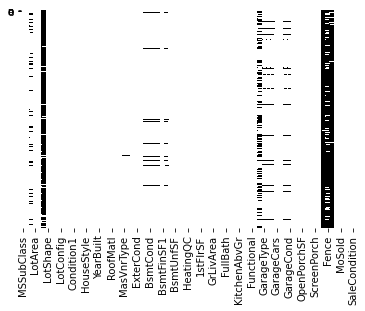

In [12]:
find_na(X_train)

<AxesSubplot:>

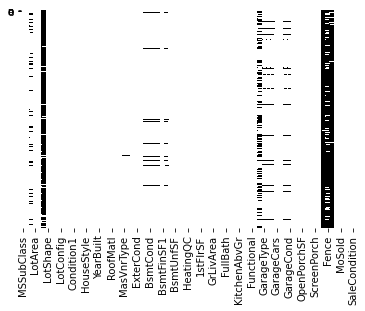

In [13]:
find_na(X_test)

In [14]:
na_sum = X_train.isna().sum().sort_values(ascending=False)
print(na_sum.loc[na_sum >= 1])
print(f'Columns with NaN values: {na_sum.loc[na_sum >= 1].count()}')

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64
Columns with NaN values: 19


### Clean 'Na' Values <a name='cleanNa'></a>
[Table of Contents](#table)

Comparing our missing values to our data dictionary many of these 'na' values are a descriptive feature of a dwelling that does not have said feature. 'PoolQC' houses without a pool don't have a 'Pool Quality' rating.

We will fill these 'na' values with 'dna' for does not apply since this is a feature in it of itself.

Column Name| 'Na' Description
-----------|---------------
MiscFeature | None
PoolQC | No Pool
Alley | No alley access
Fence | No Fence
Fireplace | No Fireplace
FireplaceQu | No Fireplace
GarageQual | No Garage
GarageYrBlt | No Garage
GarageFinish | No Garage
GarageCond | No Garage
GarageType | No Garage    
BsmtExposure | No Basement
BsmtCond | No Basement
BsmtQual | No Basement
BsmtFinType2 | No Basement
BsmtFullBath | None
BsmtHalfBath | None
GarageArea | No Garage

LotLotFrontage is a measurement.  We will fill this with '0'.
All other NA

In [53]:
dna = ['PoolQC','Alley','Fence','Fireplaces','FireplaceQu',\
       'GarageQual','GarageYrBlt','GarageFinish','GarageCond','GarageType',\
       'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFullBath',\
       'BsmtHalfBath','GarageArea','MiscFeature']

In [54]:
def impute(df, features):
    dna_imputer = SimpleImputer(fill_value='dna',strategy='constant')
    imputed_out = dna_imputer.fit_transform(df[features])
    df.loc[:,features] = imputed_out
    df['LotFrontage'].fillna(value=0,inplace=True)
    print(df.isna().sum().sort_values(ascending=False))

In [55]:
impute(X_train, dna)

SaleCondition    0
Foundation       0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
                ..
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
MSSubClass       0
Length: 79, dtype: int64


In [18]:
impute(X_test, dna)

MSZoning        4
Functional      2
Utilities       2
BsmtUnfSF       1
Exterior1st     1
               ..
KitchenAbvGr    0
TotRmsAbvGrd    0
Fireplaces      0
FireplaceQu     0
MSSubClass      0
Length: 79, dtype: int64


Minimal 'Na' values after imputation.  Dropping remaining rows with 'Na' values.

In [19]:
X_test.dropna(inplace=True)
X_train.dropna(inplace=True)

In [20]:
(X_train.isna().any or X_test.isna().any) == True

False

---

## Target Variable (SalePrice) <a name='target'></a>
[Table of Contents](#table)

---

## Continuous Features <a name='continuous'></a>
[Table of Contents](#table)

In [21]:
cont_values = X_train.select_dtypes(include='number').columns.tolist()

In [22]:
join_corr = X_train[cont_values].join(y_train,how='outer')
corr = join_corr.corr(method='spearman')

<AxesSubplot:>

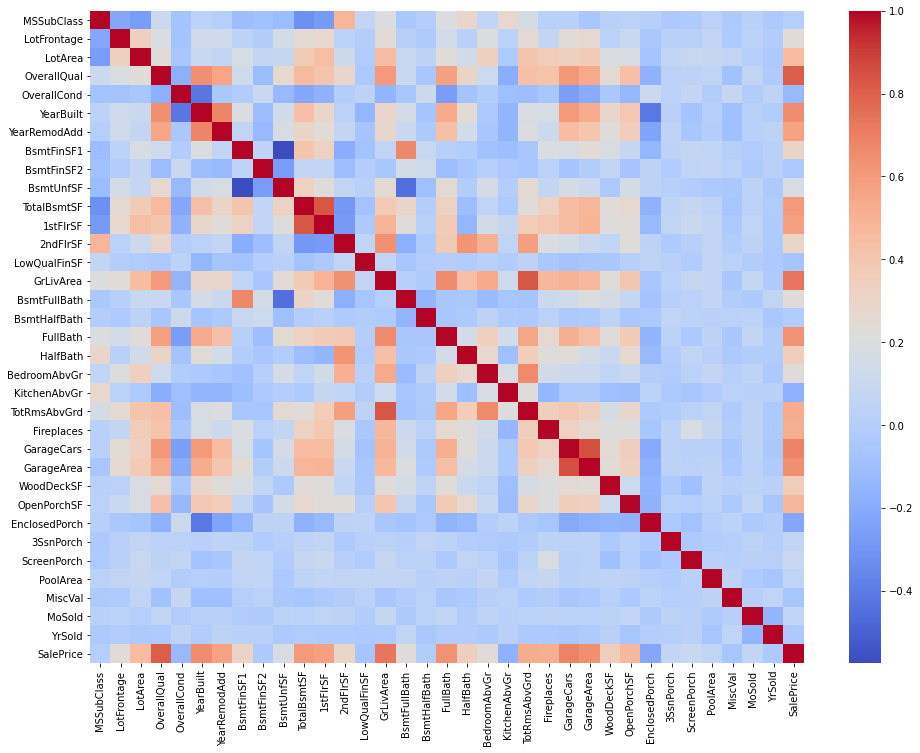

In [23]:
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap='coolwarm')

In [24]:
corr_values = X_train.loc[:,cont_values].corrwith(y_train).sort_values(ascending=False)

<AxesSubplot:>

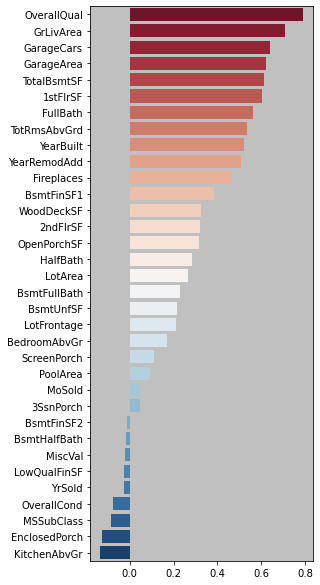

In [25]:
plt.figure(figsize=(4, len(cont_values) * .30))
plt.gca(facecolor='silver')
sns.barplot(x=corr_values,y=corr_values.index, orient='h', palette='RdBu')

In [26]:
# f_anova, p_anova = stats.f_oneway()

In [27]:
na_mean =[]
na_median =[]
na_mode =[]
na_dna =[]
   

def na_sort(column, sort):
    if column not in na_col:
        return "Column doesn't contain 'Na' values."
        
    elif sort == 'mean':
        na_mean.append(column)
    elif sort == 'median':
        na_median.append(column)
    elif sort == 'mode':
        na_mode.append(column)
    elif sort == 'dna':
        na_dna.append(column)
    else:
        return 'Unkown sort value'
    
    na_col.remove(column)
    
    print(na_col)
    print(f'Remaining columns w/ "NA" values {len(na_col)}')
    
    return

In [51]:
def scribe_stats(column, df=X_train):
    if df[column].dtype == 'O':
        df[column].value_counts(normalize=True).plot(kind='bar')
        
        print(df[column].describe())
        
    else:
        plt.subplots(1,3, figsize=(12,4))
        
        plt.subplot(1,3,1)
        df[column].hist()
        
        plt.subplot(1,3,2)
        df[column].plot(kind='box')
        
        plt.subplot(1,3,3)
        (df[column]+y_train).plot(kind='scatter')
        print(f'Skew: {df[column].skew()}, \nKurtosis: {df[column].kurtosis()},\
        \n{df[column].describe()}')
    return

ValueError: plot kind scatter can only be used for data frames

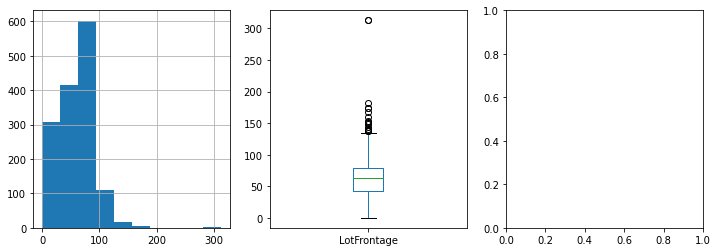

In [52]:
scribe_stats('LotFrontage')

count     1459
unique       5
top       None
freq       863
Name: MasVnrType, dtype: object
"Na" value count: 0
"Na" % missing: 0.0


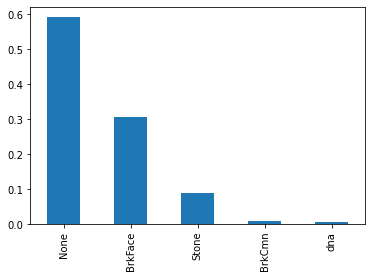

In [30]:
scribe_stats('MasVnrType')

count     1459.0
unique     328.0
top          0.0
freq       860.0
Name: MasVnrArea, dtype: float64
"Na" value count: 0
"Na" % missing: 0.0


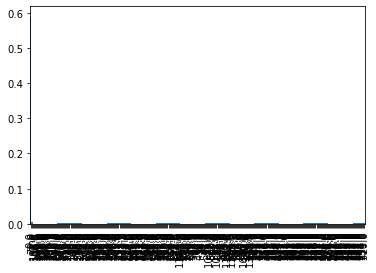

In [31]:
scribe_stats('MasVnrArea')

count     1459
unique       5
top         TA
freq       649
Name: BsmtQual, dtype: object
"Na" value count: 0
"Na" % missing: 0.0


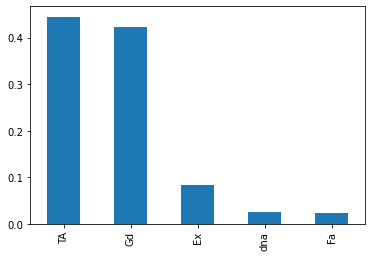

In [32]:
scribe_stats('BsmtQual')

count     1459
unique       5
top         TA
freq      1310
Name: BsmtCond, dtype: object
"Na" value count: 0
"Na" % missing: 0.0


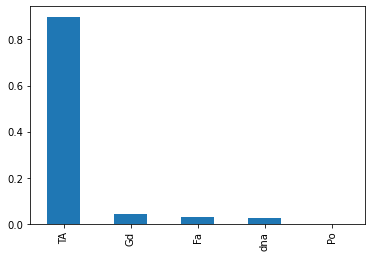

In [33]:
scribe_stats('BsmtCond')

count     1459
unique       5
top         No
freq       952
Name: BsmtExposure, dtype: object
"Na" value count: 0
"Na" % missing: 0.0


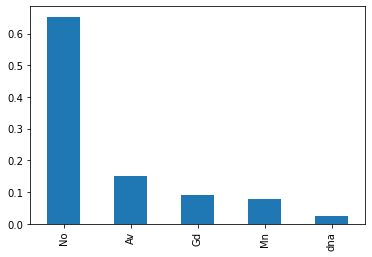

In [34]:
scribe_stats('BsmtExposure')

count     1459
unique       7
top        Unf
freq       429
Name: BsmtFinType1, dtype: object
"Na" value count: 0
"Na" % missing: 0.0


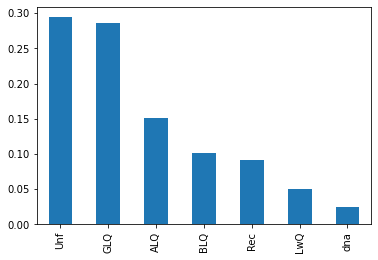

In [35]:
scribe_stats('BsmtFinType1')

count     1459
unique       7
top        Unf
freq      1255
Name: BsmtFinType2, dtype: object
"Na" value count: 0
"Na" % missing: 0.0


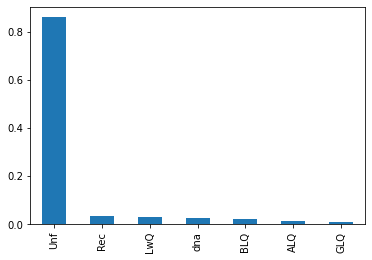

In [36]:
scribe_stats('BsmtFinType2')

count      1459
unique        5
top       SBrkr
freq       1334
Name: Electrical, dtype: object
"Na" value count: 0
"Na" % missing: 0.0


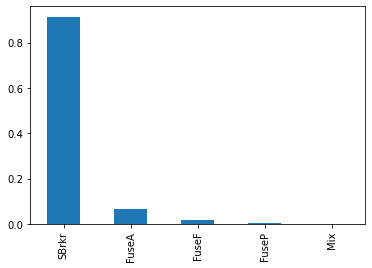

In [37]:
scribe_stats('Electrical')

count       1459
unique         7
top       Attchd
freq         870
Name: GarageType, dtype: object
"Na" value count: 0
"Na" % missing: 0.0


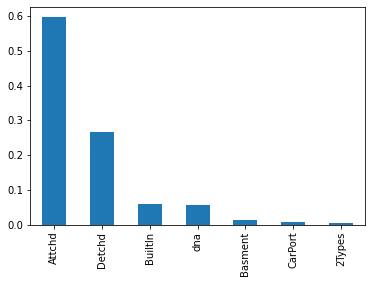

In [38]:
scribe_stats('GarageType')

count     1459
unique      98
top        dna
freq        81
Name: GarageYrBlt, dtype: object
"Na" value count: 0
"Na" % missing: 0.0


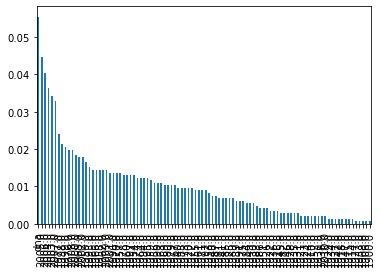

In [39]:
scribe_stats('GarageYrBlt')

count     1459
unique       4
top        Unf
freq       605
Name: GarageFinish, dtype: object
"Na" value count: 0
"Na" % missing: 0.0


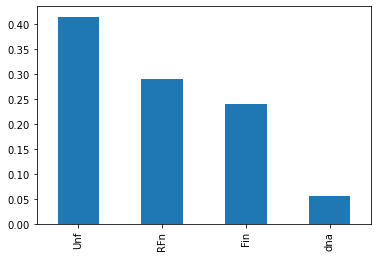

In [40]:
scribe_stats('GarageFinish')

count     1459
unique       6
top         TA
freq      1310
Name: GarageQual, dtype: object
"Na" value count: 0
"Na" % missing: 0.0


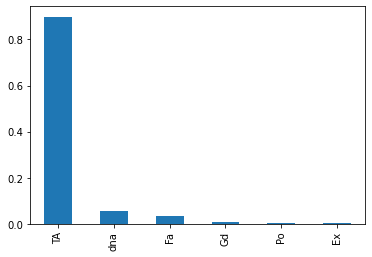

In [41]:
scribe_stats('GarageQual')

count     1459
unique       6
top         TA
freq      1325
Name: GarageCond, dtype: object
"Na" value count: 0
"Na" % missing: 0.0


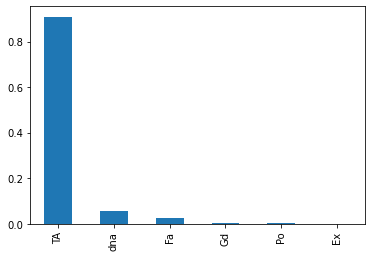

In [42]:
scribe_stats('GarageCond')

---

---

In [ ]:
def cont_scatter(df, compare, sale_price=train_data.SalePrice):
    
    plt.figure(figsize=(16,4))
    
    plt.subplot(1,3,1)
    plt.hist(df[compare])
    
    plt.subplot(1,3,2)
    plt.scatter(df[compare], sale_price)
    
    plt.subplot(1,3,3)
    plt.boxplot(df[compare])
    print(f'Median: {df[compare].median()},\nMode: {df[compare].mode()}, \
    \nSkew: {df[compare].skew()}, \nKurtosis: {df[compare].kurtosis()}, \n{df[compare].describe()}')
    
    return

In [ ]:
cont_scatter(train_data,'LotArea')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, HuberRegressor, BayesianRidge
from sklearn.model_selection import cross_val_score

### Pipeline <a name='Pipeline'></a>
[Table of Contents](#table)

In [ ]:
continuous_features = X_train.select_dtypes(np.number).columns.tolist()
categorical_features = X_train.select_dtypes('object').columns.tolist()

In [ ]:
cont_test=  X_train.select_dtypes(np.number)
cont_test.apply(lambda x: not st.shapiro(x.fillna(0))[1] > 0.01)

In [ ]:
continuous_transform = Pipeline([
    ('na_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

In [ ]:
categorical_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore')),
])

In [ ]:
preprocessor = ColumnTransformer([
    ('num', continuous_transform, continuous_features),
    ('cat', categorical_transform, categorical_features),
])

In [ ]:
linear_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Linear', LinearRegression()),
])

In [ ]:
ridge_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Ridge', Ridge(random_state=24)),
])

In [ ]:
huber_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Huber', HuberRegressor()),
])

In [ ]:
lassoCV_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Lasso', LassoCV(random_state=24, fit_intercept=True)),
])

In [ ]:
bayesian_ridge_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('BayesianRidge', BayesianRidge(n_iter=500, compute_score=True))
])

In [ ]:
pipe_list = [linear_pipe, ridge_pipe, huber_pipe]
# ,lassoCV_pipe , , , bayesian_ridge_pipe

In [ ]:
print('|Model|','\t','|RMSE Mean|','\t','|STD|','\t','|Scores|')
print('--' * 40)
for pipe in pipe_list:
    scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    scores = np.sqrt(-scores)
    print(pipe.steps[1][0],'\t',
          '{:08.6f}'.format(np.mean(scores)),'\t',
          '{:08.6f}'.format(np.std(scores)),'\t',
#          '{:08.6f}'.format(scores))
          scores)

In [ ]:
predict = 